# `xarrayvideo` for the ERA5 dataset

Notebook setup

In [1]:
#Autoreload .py files
%load_ext autoreload
%autoreload 2

#https://github.com/chmp/ipytest/issues/80
import sys
sys.breakpointhook = sys.__breakpointhook__

Load required libraries

In [2]:
import xarray as xr
import numpy as np
from pathlib import Path
from xarrayvideo import xarray2video, video2xarray, gap_fill, plot_image, to_netcdf
import matplotlib.pyplot as plt

Select the version of the dataset

In [3]:
# era5_version= '1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr' #623Tb
era5_version= '1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr' #80Tb
# era5_version= '1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr' #2Tb
# era5_version= '1959-2023_01_10-6h-64x32_equiangular_conservative.zarr' #163Gb

output_path= './out'

In [4]:
era5= xr.open_zarr(f'gs://weatherbench2/datasets/era5/{era5_version}') 
print(f'Size: {era5.nbytes / 2**30:.3f}Gb')
era5

Size: 82853.253Gb


<xarray.Dataset>
Dimensions:                                           (time: 93544,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 90.0...
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float32 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    above_ground                                      (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    vorticity                                         (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    wind_speed                                        (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>

Choose a subset of the dataset

In [5]:
#Choose a subset of the dataset
import pandas as pd
start= '2022-07-01'
data_from_start_date= era5.sel(time=slice(pd.Timestamp(start), None))

Save it locally, to avoid having to re-download every time

In [6]:
#data_from_start_date.to_zarr(f'since_{start}_{era5_version}')

Uset the locally saved data for testing

In [7]:
import pandas as pd

#Open from local
era5_version= '../since_2022-07-01_2022-07-01_1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr'

era5= xr.open_dataset(era5_version, engine='zarr')
print(f'Size: {era5.nbytes / 2**30:.3f}Gb')
era5

Size: 687.364Gb


<xarray.Dataset> Size: 738GB
Dimensions:                                           (time: 776,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 6kB ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 3GB ...
    10m_v_component_of_wind                           (time, latitude, longitude) float32 3GB ...
    10m_wind_speed                                    (time, latitude, longitude) float32 3GB ...
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 3GB ...
    2m_temperature                                    (time, latitude, longitude) float32 3GB ...
    above_ground                                      (time, level, latitude, longitude) float32 42GB ...
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, latitude, longitude) float32 3GB ...
    volumetric_soil_water_layer_2                     (time, latitude, longitude) float32 3GB ...
    volumetric_soil_water_layer_3                     (time, latitude, longitude) float32 3GB ...
    volumetric_soil_water_layer_4                     (time, latitude, longitude) float32 3GB ...
    vorticity                                         (time, level, latitude, longitude) float32 42GB ...
    wind_speed                                        (time, level, latitude, longitude) float32 42GB ...

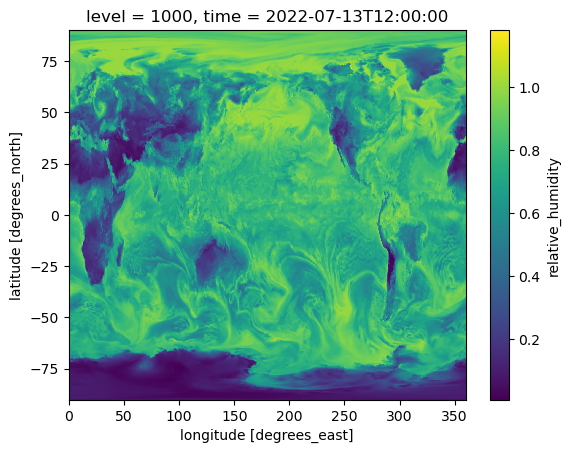

In [8]:
era5['relative_humidity'].isel({'time':50, 'level':12}).plot()
plt.show()

In [9]:
list(era5.variables)

['10m_u_component_of_wind',
 '10m_v_component_of_wind',
 '10m_wind_speed',
 '2m_dewpoint_temperature',
 '2m_temperature',
 'above_ground',
 'ageostrophic_wind_speed',
 'angle_of_sub_gridscale_orography',
 'anisotropy_of_sub_gridscale_orography',
 'boundary_layer_height',
 'divergence',
 'eddy_kinetic_energy',
 'geopotential',
 'geopotential_at_surface',
 'geostrophic_wind_speed',
 'high_vegetation_cover',
 'integrated_vapor_transport',
 'lake_cover',
 'land_sea_mask',
 'lapse_rate',
 'latitude',
 'leaf_area_index_high_vegetation',
 'leaf_area_index_low_vegetation',
 'level',
 'longitude',
 'low_vegetation_cover',
 'mean_sea_level_pressure',
 'mean_surface_latent_heat_flux',
 'mean_surface_net_long_wave_radiation_flux',
 'mean_surface_net_short_wave_radiation_flux',
 'mean_surface_sensible_heat_flux',
 'mean_top_downward_short_wave_radiation_flux',
 'mean_top_net_long_wave_radiation_flux',
 'mean_top_net_short_wave_radiation_flux',
 'mean_vertically_integrated_moisture_divergence',
 'po

Note that we can automatically get generic conversion rules (which might be suboptimal)

In [10]:
from xarrayvideo import get_recipe
from pprint import pprint as pp

conversion_rules= get_recipe(era5, t='time', x='longitude', y='latitude', c='level', bits=10)
pp(conversion_rules)

{'txy_lossy': (['10m_u_component_of_wind',
                '10m_v_component_of_wind',
                '10m_wind_speed',
                '2m_dewpoint_temperature',
                '2m_temperature',
                'boundary_layer_height',
                'eddy_kinetic_energy',
                'integrated_vapor_transport',
                'leaf_area_index_high_vegetation',
                'leaf_area_index_low_vegetation',
                'mean_sea_level_pressure',
                'mean_surface_latent_heat_flux',
                'mean_surface_net_long_wave_radiation_flux',
                'mean_surface_net_short_wave_radiation_flux',
                'mean_surface_sensible_heat_flux',
                'mean_top_downward_short_wave_radiation_flux',
                'mean_top_net_long_wave_radiation_flux',
                'mean_top_net_short_wave_radiation_flux',
                'mean_vertically_integrated_moisture_divergence',
                'sea_ice_cover',
                'sea_surface_temp

Compress

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

wind: 3374.41Mb -> ['57.03', '74.88', '115.80', '65.12', '116.97', '35.58', '41.62', '50.57', '72.29', '40.41']Mb (showing last 10)(21.26% of original size, 6.8031 bpppb) in 60.05s
 - params={'c:v': 'libx265', 'preset': 'medium', 'crf': [0], 'x265-params': 'qpmin=0:qpmax=0.001:psy-rd=0:psy-rdoq=0'}
 - Decompression time 4.63s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


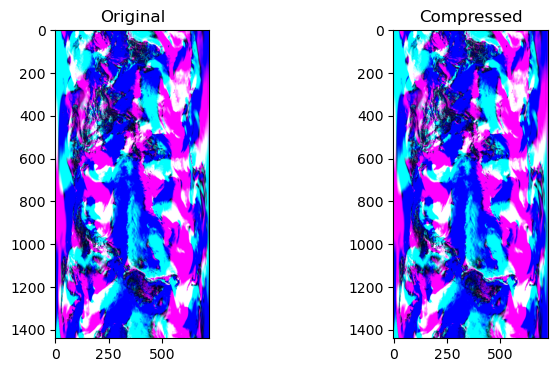

Saturation values per band ('10m_u_component_of_wind', '10m_v_component_of_wind', '10m_wind_speed')):
 [[-3.0264400e+01  3.1166637e+01]
 [-2.9498859e+01  2.8069586e+01]
 [ 3.1417224e-04  3.1332365e+01]]


/home/oscar/.conda/envs/xv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using only 11.30% of data for metrics computation. Adjust this by modifying global variable METRICS_MAX_N=100000000.0
 - SSIM_sat 0.998527
 - MSE_sat 0.005712
 - PSNR_sat 57.5642
 - Exp. SA 0.0190 
Metrics took 213.74s to run


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

relative_humidity: 14622.43Mb -> ['48.30', '144.59', '193.64', '244.81', '80.88']Mb (showing last 10)(4.87% of original size, 1.5586 bpppb) in 307.98s
 - params={'c:v': 'libx265', 'preset': 'medium', 'crf': [0], 'x265-params': 'qpmin=0:qpmax=0.001:psy-rd=0:psy-rdoq=0'}
 - Decompression time 25.12s


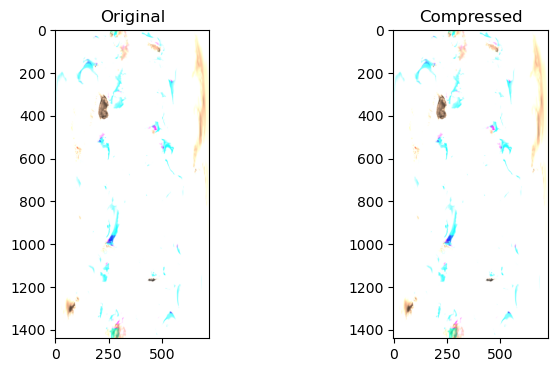

Saturation values per band ['relative_humidity_level_50', 'relative_humidity_level_100', 'relative_humidity_level_150', 'relative_humidity_level_200', 'relative_humidity_level_250', 'relative_humidity_level_300', 'relative_humidity_level_400', 'relative_humidity_level_500', 'relative_humidity_level_600', 'relative_humidity_level_700', 'relative_humidity_level_850', 'relative_humidity_level_925', 'relative_humidity_level_1000', 'relative_humidity_level_1000', 'relative_humidity_level_1000']):
 [[ 3.1670087e-04  6.5330440e-01]
 [-3.2570761e-01  8.3857614e-01]
 [-3.2499504e-01  9.7176421e-01]
 [-1.8608464e-01  9.7753972e-01]
 [-1.0369516e-01  1.1223714e+00]
 [-2.1757485e-01  1.2123638e+00]
 [-9.5167577e-02  1.3183249e+00]
 [-5.0304413e-02  1.3634442e+00]
 [ 1.6063848e-06  1.3512187e+00]
 [ 1.6726511e-06  1.3239648e+00]
 [ 8.1473689e-07  1.5417385e+00]
 [ 8.8096465e-05  1.5696980e+00]
 [ 2.4705571e-03  1.4692402e+00]
 [ 2.4705571e-03  1.4692402e+00]
 [ 2.4705571e-03  1.4692402e+00]]
Using 

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

wind_speed: 14622.43Mb -> ['47.11', '57.03', '74.88', '115.80', '65.12']Mb (showing last 10)(2.46% of original size, 0.7877 bpppb) in 244.54s
 - params={'c:v': 'libx265', 'preset': 'medium', 'crf': [0], 'x265-params': 'qpmin=0:qpmax=0.001:psy-rd=0:psy-rdoq=0'}
 - Decompression time 15.88s


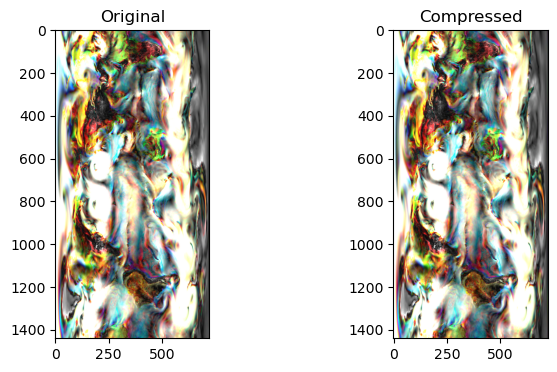

Saturation values per band ['wind_speed_level_50', 'wind_speed_level_100', 'wind_speed_level_150', 'wind_speed_level_200', 'wind_speed_level_250', 'wind_speed_level_300', 'wind_speed_level_400', 'wind_speed_level_500', 'wind_speed_level_600', 'wind_speed_level_700', 'wind_speed_level_850', 'wind_speed_level_925', 'wind_speed_level_1000', 'wind_speed_level_1000', 'wind_speed_level_1000']):
 [[6.5996741e-05 8.3274986e+01]
 [1.6135495e-04 7.9239952e+01]
 [1.9324558e-04 1.0213222e+02]
 [8.9972302e-05 1.1280654e+02]
 [1.0838690e-04 1.1939448e+02]
 [1.5567108e-04 1.0825489e+02]
 [1.3797989e-04 9.3522972e+01]
 [1.6691753e-04 8.0731613e+01]
 [6.7240806e-05 6.9419685e+01]
 [3.0044524e-05 5.9514233e+01]
 [3.4385216e-06 5.5659275e+01]
 [5.4396318e-05 5.1251278e+01]
 [5.6295317e-05 3.4167114e+01]
 [5.6295317e-05 3.4167114e+01]
 [5.6295317e-05 3.4167114e+01]]
Using only 2.61% of data for metrics computation. Adjust this by modifying global variable METRICS_MAX_N=100000000.0
 - SSIM_sat 0.999263
 - 

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

wind_u: 14622.43Mb -> ['35.58', '41.62', '50.57', '72.29', '40.41']Mb (showing last 10)(1.64% of original size, 0.5263 bpppb) in 217.26s
 - params={'c:v': 'libx265', 'preset': 'medium', 'crf': [0], 'x265-params': 'qpmin=0:qpmax=0.001:psy-rd=0:psy-rdoq=0'}
 - Decompression time 12.50s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


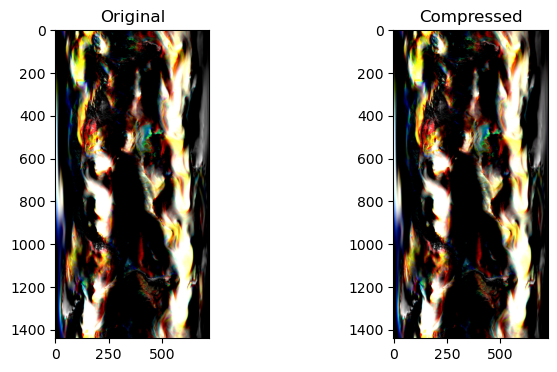

Saturation values per band ['u_component_of_wind_level_50', 'u_component_of_wind_level_100', 'u_component_of_wind_level_150', 'u_component_of_wind_level_200', 'u_component_of_wind_level_250', 'u_component_of_wind_level_300', 'u_component_of_wind_level_400', 'u_component_of_wind_level_500', 'u_component_of_wind_level_600', 'u_component_of_wind_level_700', 'u_component_of_wind_level_850', 'u_component_of_wind_level_925', 'u_component_of_wind_level_1000', 'u_component_of_wind_level_1000', 'u_component_of_wind_level_1000']):
 [[-39.137035  80.58957 ]
 [-53.16208   75.644714]
 [-43.950226 102.12832 ]
 [-50.97888  112.806274]
 [-61.141968 111.19408 ]
 [-64.24279  105.73195 ]
 [-61.511673  89.458954]
 [-51.548626  78.58211 ]
 [-49.23384   66.09289 ]
 [-47.69845   53.201397]
 [-49.89595   49.975876]
 [-50.46102   48.74789 ]
 [-31.699408  32.993694]
 [-31.699408  32.993694]
 [-31.699408  32.993694]]
Using only 2.61% of data for metrics computation. Adjust this by modifying global variable METRI

In [11]:
#Ideally, we want to manually optimize the recipe
lossy_params = {
    'c:v': 'libx265',  #[libx264, libx265, vp9, ffv1]
    'preset': 'medium',  #Preset for quality/encoding speed tradeoff: quick, medium, slow (better)
    'crf': [0],#,1,3,6,9], #14 default, 11 for higher quality and size
    'x265-params': 'qpmin=0:qpmax=0.001:psy-rd=0:psy-rdoq=0',
    }

conversion_rules= {
    'wind': ( ('10m_u_component_of_wind', '10m_v_component_of_wind', '10m_wind_speed'), ('time', 'longitude', 'latitude'), 
             0, lossy_params, 10),
    # 'wind_speed': ('wind_speed', ('time', 'longitude', 'latitude', 'level'), 0, lossy_params, 10),
    # # 'wind_speed2': ('wind_speed', ('time', 'longitude', 'latitude', 'level'), 12, lossy_params, 10),
    'relative_humidity': ('relative_humidity', ('time', 'longitude', 'latitude', 'level'), 0, lossy_params, 10),
    'wind_speed': ('wind_speed', ('time', 'longitude', 'latitude', 'level'), 0, lossy_params, 10),
    'wind_u': ('u_component_of_wind', ('time', 'longitude', 'latitude', 'level'), 0, lossy_params, 10),
    }

arr_dict= xarray2video(era5.sel(time=slice(pd.Timestamp('2022-11-01'), None)), 
                       era5_version.replace('.zarr', ''), conversion_rules,
                       output_path=output_path, compute_stats=True,
                       loglevel='verbose', #verbose, quiet
                       save_dataset=False #Disable saving
                       )  